# TOTEMS - Tidal Orbital decay Timing Extrapolation & Modelling Software
**Ross Dobson, last update 2020-11-22 | [Github](https://github.com/Ross-Dobson/TOTEMS)**

# Introduction
This code analyses Exoplanet mid-transit times $t_\text{mid}$ for signs of orbital decay, specifically those caused by tidal interaction. It also attempts to ascertain between these, or the similar effects of apsidal precession of the orbit. I provide an example of doing this with WASP-12b. This code was originally written solely by me as my contribution to a group project during my undergrad at University College London; it has been considerably rewritten and improved upon since then.

## Theory
Consider that a stable, circular orbit with no decay can be modelled as:

$$ t(E)=t_0+P\times{E}, $$ where $E$ is the epoch number of periods/transits since the reference mid-time $t_0$, and $P$ is the orbital period.

A decaying orbit due to tidal decay can be modelled as

$$ t(E)=t_0+P\times{E} + \frac{1}{2}\frac{dP}{dE}E^2, $$

and apsidal precession can be modelled as

$$ t(E)=t_0+P_s\times{E} - \frac{eP_a}{\pi}\cos\left({\omega(E)}\right)$$ where orbital period is now $P_s$, the sidereal period, to distinguish from anomalistic period $P_a=P_s\left(1-\frac{d\omega/dE}{2\pi}\right)^{-1} $, and the argument of pericenter evolves as $ \omega(E) = \omega_0 + \frac{d\omega}{dE}E $. 

Reference: [Kishore C. Patra *et al* 2017 AJ 154 4](https://doi.org/10.3847/1538-3881/aa6d75)

## Data Preparation

Prepare a CSV with three columns: the mid-time in Julian Date, the uncertainty on this, and the type of JD: either HJD_UTC, HJD_TDB, BJD_UTC, BJD_TDB. All times will be converted if necessary to BJD_TDB automatically.

Alternatively, or in addition, mid-time data can be imported from the [Exoplanet Transit Database](http://var2.astro.cz/ETD/). However, this comes from a variety of sources of differing quality, so it in the authors experience is best to avoid using solely this data.

If you have values for the (initial) orbital period $P_0$ and the mid-time for epoch 0, $t_0$, you can input these; else the value for $P_0$ will be obtained from ETD, the value for $t_0$ will be set at the earliest $t_\text{mid}$.

To convert mid-times into BJD$_\text{TDB}$, the [`pylightcurve`](https://github.com/ucl-exoplanets/pylightcurve) module is utilised. This was initially provided to me by Dr. Angelos Tsiaras of University College London.

In [35]:
!pip install pylightcurve

In [36]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

#Import curve fitting (Which is what we need for tidal decay)
from scipy.optimize import curve_fit

#Import pylightcurve, used for BJD HJD conversions - thanks to Angelos Tsiaras
import pylightcurve as plc

In [37]:
%matplotlib inline

## Planet properties

Using the [Open Exoplanet Catalogue](https://github.com/OpenExoplanetCatalogue/open_exoplanet_catalogue), we can automatically obtain a large number of parameters for most exoplanets. A lot of this information is loaded from NASA Exoplanet Archive, see the Github for more information.


In [38]:
import xml.etree.ElementTree as ET, urllib.request, gzip, io
oec_url = "https://github.com/OpenExoplanetCatalogue/oec_gzip/raw/master/systems.xml.gz"
oec = ET.parse(gzip.GzipFile(fileobj=io.BytesIO(urllib.request.urlopen(oec_url).read())))

A list of all planets in the database (to check if your target is there) can be generated with:

```
for planet in oec.findall(".//planet"):
    print(planet.findtext("name"))
```
Beware this produces a long list.

---
The below function returns the Right Ascension (hh mm ss.ss), Declination (dd mm ss.ss), Eccentricity $e$, orbital period $P$ (days), and Argument of Periastron $\omega$ (deg).


In [39]:
def get_oec_planet_data(planet_name):
    """Obtains RA, Dec, e, P, and Periastron from Open Exoplanet Catalogue.

    Also prints the full system and planetary properties. Planet name needs to 
    match one on the list. To see the full list, run::

        for planet in oec.findall(".//planet"):
            print(planet.findtext("name"))
    
    Parameters
    ----------
    planet_name : string
        The name of the exoplanet to get the OEC data of.

    Returns
    -------
    ra : string
        Right Ascension of the system, format hh mm ss.ss
    dec : string
        Declination of the system, format dd mm ss.ss
    period : float
        Period of the planetary orbit in days
    eccentricity : float
        Eccentricity of the planetary orbit
    periastron : float
        Argument of periastron of the orbit (degrees)

    Notes
    -----
    If a value is not present in the catalogue, a None will be returned.
    """
    system_name = planet_name.split()[0]

    print("System Properties:")
    for properties in oec.findall(".//system[name='{0}']/*".format(system_name)):
        print("\t" + properties.tag + ":", properties.text)

    print("Planet Properties:")
    for properties in oec.findall(".//planet[name='{0}']/*".format(planet_name)):
        print("\t" + properties.tag + ":", properties.text)

    for system in oec.findall(".//system[name='{0}']".format(system_name)):
        ra = system.findtext("rightascension")
        dec = system.findtext("declination")

    for planet in oec.findall(".//planet[name='{0}']".format(planet_name)):
        period = planet.findtext("period")
        eccentricity = planet.findtext("eccentricity")
        periastron = planet.findtext("periastron")

    return ra, dec, period, eccentricity, periastron

planet_name='WASP-12 b'
wasp12_ra, wasp12_dec, wasp12_period, wasp12_eccentricity, wasp12_periastron = get_oec_planet_data(planet_name)

System Properties:
	name: WASP-12
	rightascension: 06 30 33
	declination: +29 40 20
	distance: 250
	binary: 
		
Planet Properties:
	name: WASP-12 b
	name: WASP-12 A b
	name: 2MASS J06303279+2940202 b
	list: Confirmed planets
	mass: 1.404
	radius: 1.736
	period: 1.0914222
	semimajoraxis: 0.02293
	eccentricity: 0.0
	inclination: 86
	spinorbitalignment: 59
	transittime: 2454508.98074
	discoverymethod: transit
	lastupdate: 13/07/31
	description: The host star of WASP-12 b is the primary of a hierarchical triple system. The distant binary consists of two M dwarfs.
	discoveryyear: 2008
	temperature: 2319.7
	list: Planets in binary systems, S-type
	istransiting: 1


## Transit times



One option is to get data from the [Exoplanet Transit Database](http://var2.astro.cz/ETD). This data tends to be from multiple sources of differing techniques and quality, however. In the author's experience, it should be used only as a last resort, or alongside data from any recent paper.

In [40]:
wasp12_etd_url = 'http://var2.astro.cz/ETD/ascii-etd.php?id=246&STARNAME=WASP-12&PLANET=b&PER=1.0914222&EPOCH=2454508.97605'

If using solely ETD data, it probably makes sense to use their values of $P_0$ and $t_0$, inheriting their epoch system.

In [41]:
def get_etd_p0_t0(etd_url):
    """Obtains the values of P_0 (period) and t_0 (tmid at epoch 0) from ETD.
    
    Parameters
    ----------
    etd_url : string
        The URL to the .csv file for the planet on ETD.

    Returns
    -------
    p0
    """
    # Load in the row, split in two via delimeter choice.
    p_str, t_str = np.loadtxt(etd_url, dtype=str, encoding='unicode_escape', delimiter=', ', skiprows=2, max_rows=1)
    
    # Now get just the number, lose everything else.
    for token in p_str.split():
        try:
            p0 = float(token)
        except ValueError:
            pass # if its not the number, move on
    for token in t_str.split():
        try:
            t0 = float(token)
        except ValueError:
            pass # if its not the number, move on

    return p0, t0

wasp12_etd_p0, wasp12_etd_t0 = get_etd_p0_t0(wasp12_etd_url)
print(wasp12_etd_p0, wasp12_etd_t0)

1.0914222 2454508.97605


This function gets the transit data for the exoplanet from the [Exoplanet Transit Database](http://var2.astro.cz/ETD). Use this if you don't
have any archive data of your own to use, though really any data from a recent paper will probably be better.

Requires RA and Dec to convert from HJD_UTC to BJD_TDB.

In [42]:
def get_etd_data(right_ascension, declination, etd_url):
    """Imports the data from ETD. Uses RA & Dec to convert HJD_UTC to BJD_TDB.
    
    Parameters
    ----------
    right_ascension : string
        The right ascension in hh mm ss.ss
    declination : string
        The declination in dd mm ss.ss
    etd_url : string
        The URL of the ETD .csv datafile

    Returns
    -------
    data : Dataframe
        A Pandas DataFrame with bjd, mid_err, dq. These are the mid-time 
        in BJD_TDB, the uncertainty of the mid-time, and the ETD Data Quality 
        factor, where 1 is best and 5 is worst. The index is the row numbers 
        from ETD, we keep this as an arbitrary index for now.
    """

    # Note that we keep ETD's index numbers for now, for convenience. Having
    # tmid as the index makes manipulation of it a lot harder.

    # Columns that we want from the CSV.
    csv_headers = ['#', 'HJDmid', 'HJDmid Error', 'DQ']

    # What we want to name the columns in our DataFrame.
    cols = ['tmid', 'err', 'DQ']

    # Now to import the actual transit data.
    data = pd.read_csv(etd_url, delimiter=';', header=0, index_col=0,
                       usecols=csv_headers, skiprows=4)
    
    # Set the columns to the names we want.
    data.index.rename('number', inplace=True)  # row header
    data.columns = cols  # columns

    # Convert from the truncated HJD to the full HJD.
    data['tmid'] = data['tmid'].apply(lambda x: x + 2400000)

    # Assuming (fairly certain) ETD uses HJD_UTC, let's convert to BJD_TDB.
    # Of course, it might be worth checking that each individual data point
    # is actually in HJD, rather than e.g. BJD already, as ETD doesn't check it.
    ra_dec_string = right_ascension+" "+declination
    ra, dec = plc.ra_dec_string_to_deg(ra_dec_string)

    # Convert to BJD_TDB; we assume uncertainty remains the same for HJD or BJD
    bjd = np.array([])
    for (col, value) in data['tmid'].iteritems():
        bjd = np.append(bjd, plc.hjd_utc_to_bjd_tdb(ra, dec, value))

    return data

etd_data = get_etd_data(wasp12_ra, wasp12_dec, wasp12_etd_url)

etd_data

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


,tmid,err,DQ
number,,,
262,2.459148e+06,0.00073,3
261,2.459089e+06,0.00136,2
260,2.458930e+06,0.00052,1
259,2.458906e+06,0.00060,2
258,2.458895e+06,0.00263,3
...,...,...,...
5,2.454841e+06,0.00047,1
4,2.454837e+06,0.00130,4
3,2.454837e+06,0.00156,3


In [43]:
def filter_etd_data(data, filter):
    """Filters ETD data to DQ<=filter. Checks uncertainty exists else deletes.

    ETD has it so that the best DQ is 1, the worst DQ is 5. By checking whether
    the transit mid-time has an associated uncertainty, we can discard the most
    egregious datapoints that are scientifically useless for us.

    Parameters
    ----------
    data : DataFrame
        The dataframe of ETD data to be filtered.
    filter : int
        The value of DQ for which transits with DQ greater than this should be 
        discarded.
    
    Returns
    -------
    filtered_data : DataFrame
        DataFrame of ETD data with DQ <= filter
    """

    # Use only values where an uncertainty exists, and isn't somehow negative 
    # (e.g. debug values of -9999 making it into the dataset!)
    filtered_data = data[data.err.notnull()]
    filtered_data = filtered_data[filtered_data.err > 0]
    
    # filter by DQ
    print("Before filtering:", len(data.index), "transits.")
    print("Filtering values with DQ filter {0}.".format(filter))
    filtered_data = filtered_data[filtered_data.DQ <= filter]
    print("After filtering:", len(filtered_data.index), "transits.")

    filtered_data.drop('DQ', axis='columns', inplace=True)

    return filtered_data

# Setting to lower filter values is better. Set to 2 as an example.
filtered_etd_data = filter_etd_data(etd_data, 2)

Before filtering: 262 transits.
Filtering values with DQ filter 2.
After filtering: 101 transits.


In [44]:
def add_own_data(right_ascension, declination, fpath):
    """Function to add your own data from csv, with format tmid, err, JD type.

    JD type needs to be one of "HJD_UTC", "HJD_TDB", "BJD_UTC", or "BJD_TDB". If
    necessary, these will be converted to BJD_TDB.

    Parameters
    ----------
    right_ascension : string
        The right ascension in hh mm ss.ss
    declination : string
        The declination in dd mm ss.ss
    fpath : string
        The path to your .csv datafile, local path or URL

    Returns
    -------

    data : pandas DataFrame 
        Pandas Dataframe with bjd, mid_err. These are the mid-time in BJD_TDB,
        and the uncertainty of said mid-time. The index is an arbitrary index
        for now, automatically generated.
    """

    # import all the data as NumPy arrays. We'll make a df at the end.
    # genfromtxt has a bug/"feature" at not unpacking if dtype=None (where it 
    # guesses the dtype), so we have to import all of itas strings, then change 
    # mid and err to floats afterwards.
    mid, err, jd_type = np.genfromtxt(fpath, unpack=True, dtype=str, skip_header=1, encoding='unicode_escape', delimiter=',', missing_values='')
    mid, err = mid.astype(float), err.astype(float)

    # Prepare for BJD conversion
    bjd=np.array([])
    ra_dec_string = right_ascension+" "+declination
    ra, dec = plc.ra_dec_string_to_deg(ra_dec_string)

    # Check if we need to convert to BJD
    for i, jd in enumerate(mid):
        if jd_type[i] == "BJD_TDB":
            bjd = np.append(bjd, jd)
        elif jd_type[i] == "HJD_UTC":
            bjd = np.append(bjd, plc.hjd_utc_to_bjd_tdb(ra, dec, jd))
        elif jd_type[i] == "HJD_TDB":
            bjd = np.append(bjd, plc.hjd_tdb_to_bjd_tdb(ra, dec, jd))
        elif jd_type[i] == "BJD_UTC":
            bjd = np.append(bjd, plc.bjd_utc_to_bjd_tdb(ra, dec, jd))
        else:
            # i+2 as csv will count from 1, and +1 for the header
            raise ValueError("Type needs to be \'BJD_TDB\', \'HJD_UTC\', \'HJD_TDB\' or \`BJD_UTC\`. Check csv row",i+2)

    # Make a DataFrame for our NumPy arrays, set the columns
    own_data = pd.DataFrame(data=(np.array([bjd,err]).T))
    own_data.columns = ['tmid', 'err']

    return own_data


own_data = add_own_data(wasp12_ra, wasp12_dec, 'example_data_WASP12b.csv')
own_data

,tmid,err
0,2454515.525,0.00043
1,2454836.403,0.00028
2,2454840.769,0.00062
3,2455140.910,0.00042
4,2455147.459,0.00043
...,...,...
96,2457765.775,0.00028
97,2457766.866,0.00039
98,2457776.689,0.00029
99,2457788.695,0.00048


If using both own and ETD data, join the two together.

In [45]:
data = pd.concat([filtered_etd_data, own_data])
data

,tmid,err
261,2.459089e+06,0.00136
260,2.458930e+06,0.00052
259,2.458906e+06,0.00060
257,2.458884e+06,0.00070
256,2.458883e+06,0.00054
...,...,...
96,2.457766e+06,0.00028
97,2.457767e+06,0.00039
98,2.457777e+06,0.00029
99,2.457789e+06,0.00048


In [46]:
def epoch_calculator(df, p0, t0):
    """Calculates epochs for a df. Needs a P0 & T0 (or use ETD & earliest tmid). 

    Parameters
    ----------
    df : pandas DataFrame
        DataFrame of tmids and uncertainties
    p0 : float
        Period of exoplanet orbit in days
    t0 : float
        Reference mid-time for epoch 0, in BJD_TDB
    
    Returns
    -------
    sorted_df : pandas DataFrame 
        DataFrame with new epoch column, sorted by tmid.

    Raises
    ------
    ValueError
        If P0 or T0 are negative.

    Notes
    -----
        Supply a P0 and T0. If you have your own values, e.g. from a paper, pass
        these in. Else, consider using either ETD's values with get_etd_p0_t0(),
        or use the period provided by EOC, and use one of your tmid values; 
        earliest or median are good choices to see trends clearly, use 
        df.tmid.min() or df.tmid.median() to obtain.

    """
    if (p0<=0):
        raise ValueError("Period cannot be negative")

    if (t0<=0):
        raise ValueError("Mid-times cannot be negative")

    # Calculate the epoch system, assume closest rounding is correct via np.rint
    # Epoch is calculated assuming a constant-period stable circular orbit.
    df['epoch'] = data['tmid'].apply(lambda x: np.rint((x-t0)/p0) )
    df['epoch'] = pd.Series(df['epoch'], dtype=int)  # make sure it's integer

    # sort by tmid, and replace the index with sequential numbers
    sorted_df = df.sort_values('tmid', ignore_index=True)
    return sorted_df
    
data = epoch_calculator(data, wasp12_etd_p0, wasp12_etd_t0)
data

,tmid,err,epoch
0,2.454509e+06,0.00020,0
1,2.454516e+06,0.00043,6
2,2.454836e+06,0.00060,300
3,2.454836e+06,0.00028,300
4,2.454841e+06,0.00047,304
...,...,...,...
197,2.458883e+06,0.00054,4008
198,2.458884e+06,0.00070,4009
199,2.458906e+06,0.00060,4029
200,2.458930e+06,0.00052,4051


## Fitting models

### 1. Linear: Stable orbit, constant period

If this is the case, and the exoplanet has no orbital decay, then we expect that using the first formula $t = t_0 + PE$ should have no difference from our recorded mid-times. We fit the linear model to the data using `curve_fit`, and then we generate an O-C graph of this scenario:

In [47]:
def linear_curve(E,t0,P):
    '''Formula for circular orbit with constant period.

    Parameters
    ----------
    E : int
        The epoch for this mid-time
    t0 : float
        Reference mid-time for epoch 0, in BJD_TDB
    P : float
        Orbital period in days

    Returns
    -------
    tmid : float
        the tmid for a constant period circular orbit, at that epoch
    '''
    return t0+(P*E)

To get the parameters that best fit the data to the function, we used the Levenberg-Marquadt algorithm in `scipy.curve_fit`:

In [48]:
param_guess = [wasp12_etd_t0, wasp12_etd_p0]
pars_linear, cov_linear = curve_fit(linear_curve, data.epoch, data.tmid, param_guess, method='lm')

# so this should be the t_0 and P_guess that minimise chi-sq
t0_linear, P_linear = pars_linear

print(pars_linear)
print(cov_linear)

[2.45450898e+06 1.09141981e+00]
[[ 8.90403998e-08 -3.62457310e-11]
 [-3.62457310e-11  1.83687456e-14]]


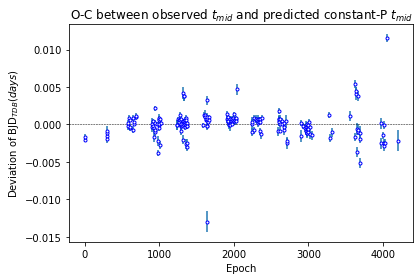

In [49]:
plt.figure()

# Use the formula to generate the expected tmid at each epoch we have observations at
tmid_const = data['epoch'].apply(lambda E: linear_curve(E, t0_linear, P_linear))

# O-C between our observed tmids and these expected tmids
OC = pd.Series(data=(data['tmid'] - tmid_const))

plt.errorbar(data['epoch'], OC, xerr=0, yerr=data['err'], linestyle='None', marker='.', mfc="w", mec="b")
plt.axhline(y=0, xmin=0.0, xmax=1.0, color='black', linestyle='dashed', linewidth=0.5)
plt.ylabel('Deviation of BJD$_{TDB} (days)$')
plt.xlabel('Epoch')
plt.title('O-C between observed $t_{mid}$ and predicted constant-P $t_{mid}$')
plt.show()

We can see some outliers, so we will sigma-clip the O-C, and use the index of the resulting Series to clip our DataFrame.

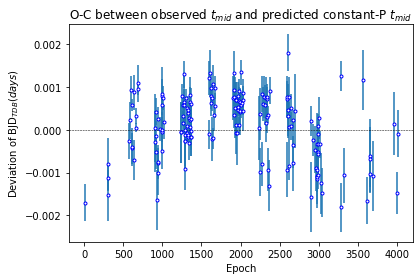

In [50]:
# Sigma-clip the OC Series
OC = OC[((OC-OC.mean()).abs() <= 1*(OC.std()))]

# Apply the index to the main DataFrame
data = data.loc[OC.index]

plt.errorbar(data['epoch'], OC, xerr=0, yerr=data['err'], linestyle='None', marker='.', mfc="w", mec="b")
plt.axhline(y=0, xmin=0.0, xmax=1.0, color='black', linestyle='dashed', linewidth=0.5)
plt.ylabel('Deviation of BJD$_{TDB} (days)$')
plt.xlabel('Epoch')
plt.title('O-C between observed $t_{mid}$ and predicted constant-P $t_{mid}$')
plt.show()

In this case, we can see that it isn't a straight line, it follows a trend, that could be descibed as possibly quadratic (tidal orbital decay) or the beginning of a sinusoidal curve (apsidal precession).

## Statistics functions

These functions are for the $\chi^2$ comparison. I sincerely doubt that I haven't accidentally reinvented the wheel - functions for this probably already exist in something like SciPy. However, it's so simple, I've not exactly wasted hours on these.

Equations are from "Measurements and Their Uncertainties: A Practical Guide to Modern Error Analysis: Hughes and
Hase 2010".

$$ \chi^2 = \sum_i{\frac{y_i-y(x_i)}{\alpha_i^2}}$$

$\nu$ is the degrees of freedom: the number of datapoints minus the number of fitted parameters. We divide $\chi^2$ by
 $\nu$ to obtain the reduced chi-squared, as follows:

$$ \chi^2_\text{reduced} = \frac{\chi^2}{\nu} $$

In [51]:
def chi_squared(y_i,yx,alpha):
    """Calculates the unreduced chi squared.
    Inputs:
    - y_i, the array of observed y value (the y_i in the formula)
    - yx, the array of y values of the fitted line (the y(x) in the formula )
    - alpha, array of error in y, in the same units as y
    Outputs:
    - chi2, the unreduced chi squared value
    """

    chi2=0
    for i,y in enumerate(y_i):
        chi2 += ((y-yx[i])**2) / (alpha[i]**2)
    return chi2

def reduced_chi_squared(y,yx,alpha,m):
    """Calculates the reduced chi squared from the raw data: just chisq divided by degrees of freedom
    Degree of freedom is just number of observations n - number of fitted parameters m
    where n is just the number of y (or y(x) or x) values
    Inputs:
    - y, array of actual observed y value (the y_i in the formula)
    - yx, array of y value of the fitted line (the y(x) in the formula )
    - alpha, array of error in y, in the same units as y
    - m, the number of fitted parameters.
    Outputs:
    - chi2, the unreduced chi squared value
    """
    n = len(y) # number of observations/datapoints
    dof = n-m # degree of freedom, m is fitted params
    chi2 = chi_squared(y,yx,alpha) # get the unreduced chi squared
    reduced_chi2 = chi2/dof # reduce it
    return reduced_chi2